# Crazy Climber — Deep Q-Learning (DQN) Baseline

This notebook documents my full assignment workflow for **LLM Agents & Deep Q-Learning with Atari Games** using **ALE/CrazyClimber-v5**.

**What this notebook provides (so far):**
- ✅ Environment setup, preprocessing, and a basic DQN architecture (Checkpt 1)
- ✅ Baseline training run with logging/artifacts (Checkpt 2)
- ✅ Baseline performance write-up aligned to rubric (Checkpt 3)
- 📈 Visuals: frame-stack preview, returns/steps/epsilon plots, config table




In [8]:
# Core
import json, os, csv, math
from pathlib import Path

# Numerics & viz
import numpy as np
import matplotlib.pyplot as plt

# Project paths
ROOT = Path.cwd().resolve()
RUNS = ROOT / "runs" / "baseline"
METRICS_CSV = RUNS / "metrics.csv"
CONFIG_JSON = RUNS / "config.json"

print("ROOT:", ROOT)
print("Expecting metrics at:", METRICS_CSV)
print("Expecting config at:", CONFIG_JSON)


ROOT: /Users/akshayagavhane/Desktop/crazyclimber-dqn/notebooks
Expecting metrics at: /Users/akshayagavhane/Desktop/crazyclimber-dqn/notebooks/runs/baseline/metrics.csv
Expecting config at: /Users/akshayagavhane/Desktop/crazyclimber-dqn/notebooks/runs/baseline/config.json


In [9]:
# --- Project import setup (recommended: package-style) ---
import sys
from pathlib import Path

# 1) Point ROOT to your repo folder (edit only if your path is different)
ROOT = Path("/Users/akshayagavhane/Desktop/crazyclimber-dqn").resolve()
SRC = ROOT / "src"

# 2) Put the *project root* (parent of 'src') on sys.path
#    This is the key: to import "src.something", Python must see ROOT on sys.path.
if str(ROOT) not in sys.path:
    sys.path.append(str(ROOT))

print("ROOT:", ROOT)
print("Has src/__init__.py:", (SRC / "__init__.py").exists())
print("ROOT on sys.path:", str(ROOT) in sys.path)

# 3) Now package-style imports work everywhere (VS Code, Cursor, CLI)
from src.wrappers import make_crazyclimber_env
from src.networks import QNetwork

print("Imports OK.")


ROOT: /Users/akshayagavhane/Desktop/crazyclimber-dqn
Has src/__init__.py: True
ROOT on sys.path: True
Imports OK.


## Preprocessing Visuals
We use:
- `AtariPreprocessing(grayscale=True, screen_size=84, frame_skip=1, scale_obs=True)`
- `FrameStack(4)`

ALE v5 already applies frame-skip internally, so wrapper `frame_skip=1` avoids double-skipping.


A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]
/var/folders/6z/dycfwtp50qz26wr9j1gsb9km0000gn/T/ipykernel_80703/624093533.py:9: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  arr = np.array(obs)   # Either (4,84,84) or (84,84,4)


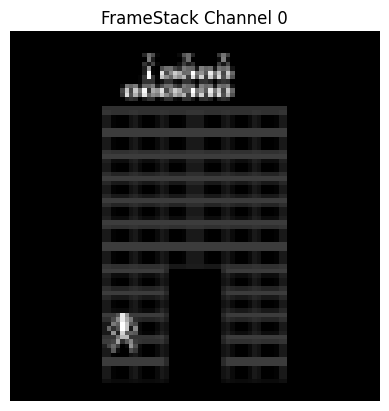

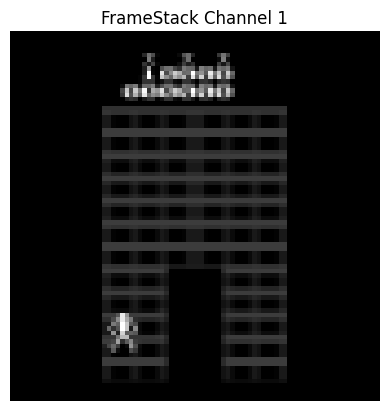

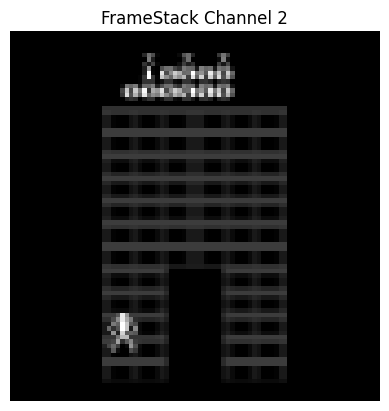

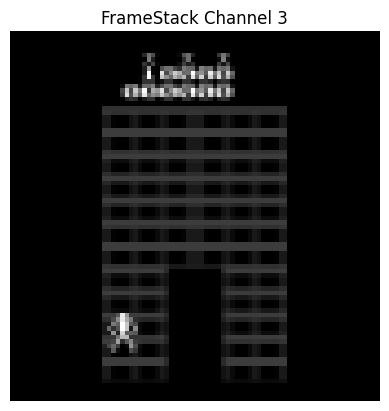

In [10]:
# Visualize stacked frames (uses your src wrappers)
import sys
sys.path.append(str(ROOT / "src"))

from wrappers import make_crazyclimber_env

env = make_crazyclimber_env(seed=7, render_mode=None)
obs, _ = env.reset()
arr = np.array(obs)   # Either (4,84,84) or (84,84,4)

# Ensure channels-last for plotting
if arr.shape == (4, 84, 84):
    # (C,H,W) -> (H,W,C)
    arr_vis = np.transpose(arr, (1, 2, 0))
else:
    arr_vis = arr

# Plot each channel separately
for i in range(arr_vis.shape[-1]):
    plt.figure()
    plt.title(f"FrameStack Channel {i}")
    plt.imshow(arr_vis[..., i], cmap="gray")
    plt.axis("off")
    plt.show()

env.close()


## Smoke Test
Quick check that:
- Env resets and steps
- QNetwork compiles and does a forward pass on real data
- Device is MPS on macOS (or CPU fallback)


In [11]:
# Re-run the lightweight smoke test logic in-notebook
from networks import QNetwork

def ensure_chw(x: np.ndarray) -> np.ndarray:
    if x.ndim != 3:
        raise ValueError(f"Expected 3D obs, got {x.shape}")
    if x.shape[0] == 4:        # (4,84,84)
        return x
    if x.shape[-1] == 4:       # (84,84,4)
        return np.transpose(x, (2,0,1))
    raise ValueError(f"Unexpected obs shape {x.shape}")

env = make_crazyclimber_env(seed=123, render_mode=None)
obs, _ = env.reset()
obs_np = ensure_chw(np.array(obs))

n_actions = 9
qnet = QNetwork(n_actions)
print("Obs CHW shape:", obs_np.shape)
print("QNet ready with actions:", n_actions)
env.close()


Obs CHW shape: (4, 84, 84)
QNet ready with actions: 9


/var/folders/6z/dycfwtp50qz26wr9j1gsb9km0000gn/T/ipykernel_80703/2590262137.py:15: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  obs_np = ensure_chw(np.array(obs))


## ✅ Checkpoint 2 — Baseline Training (Run in Terminal, Visualize Here)

We trained the baseline DQN via terminal (more reliable for long runs).
This notebook loads the saved artifacts and produces:
- Episode return plot (+ rolling average)
- Steps per episode
- Epsilon schedule
- A short, rubric-aligned write-up


In [12]:
from pathlib import Path
import json, csv, numpy as np

ROOT = Path("/Users/akshayagavhane/Desktop/crazyclimber-dqn").resolve()
RUNS = ROOT / "runs" / "baseline"
METRICS_CSV = RUNS / "metrics.csv"
CONFIG_JSON = RUNS / "config.json"

print("ROOT:", ROOT)
print("Artifacts exist?")
print(" - metrics.csv:", METRICS_CSV.exists())
print(" - config.json:", CONFIG_JSON.exists())

if not METRICS_CSV.exists() or not CONFIG_JSON.exists():
    raise FileNotFoundError("Baseline artifacts not found. Run `python train_dqn.py` in the terminal first.")


ROOT: /Users/akshayagavhane/Desktop/crazyclimber-dqn
Artifacts exist?
 - metrics.csv: True
 - config.json: True


In [13]:
# Load metrics
episodes, returns, steps, epsilons = [], [], [], []
with open(METRICS_CSV) as f:
    reader = csv.DictReader(f)
    for row in reader:
        episodes.append(int(row["episode"]))
        returns.append(float(row["return"]))
        steps.append(int(row["steps"]))
        epsilons.append(float(row["epsilon"]))

episodes = np.array(episodes)
returns  = np.array(returns, dtype=np.float32)
steps    = np.array(steps, dtype=np.int32)
epsilons = np.array(epsilons, dtype=np.float32)

# Load config
with open(CONFIG_JSON) as f:
    config = json.load(f)

print(f"Episodes loaded: {len(episodes)}")
print("First 3 rows:", list(zip(episodes[:3], returns[:3], steps[:3], epsilons[:3])))
print("\nKey config:")
for k in ["gamma","lr","batch_size","warmup_steps","eps_start","eps_end","eps_decay_episodes","tau","max_steps_per_ep","total_episodes","device"]:
    if k in config:
        print(f" - {k}: {config[k]}")


Episodes loaded: 50
First 3 rows: [(np.int64(1), np.float32(4600.0), np.int32(1773), np.float32(1.0)), (np.int64(2), np.float32(3400.0), np.int32(1464), np.float32(0.97625)), (np.int64(3), np.float32(8700.0), np.int32(3000), np.float32(0.9525))]

Key config:
 - gamma: 0.99
 - lr: 0.0001
 - batch_size: 64
 - warmup_steps: 10000
 - eps_start: 1.0
 - eps_end: 0.05
 - eps_decay_episodes: 40
 - tau: 0.005
 - max_steps_per_ep: 3000
 - total_episodes: 50
 - device: mps


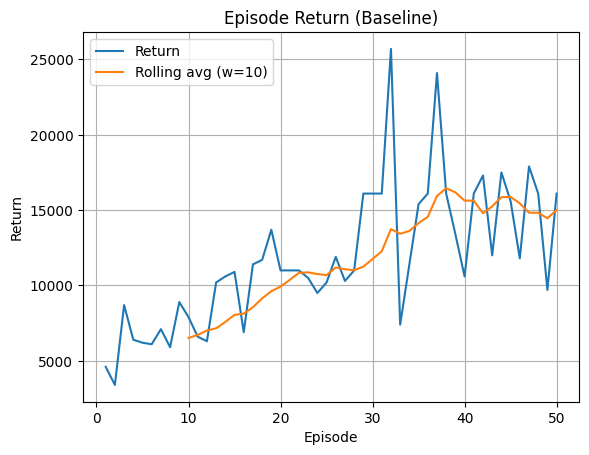

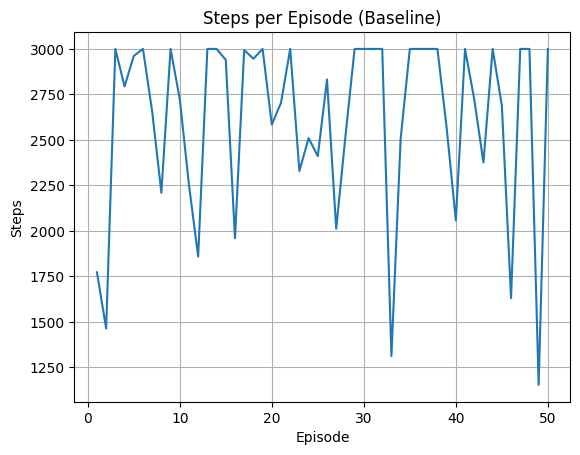

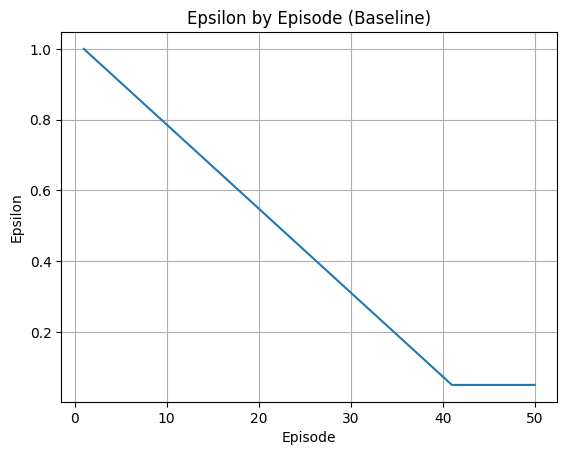

In [14]:
import matplotlib.pyplot as plt
import numpy as np

def rolling_avg(x, w=10):
    if len(x) < w:
        return x.astype(np.float32)
    out = np.convolve(x, np.ones(w)/w, mode="valid")
    pad = np.full(w-1, np.nan, dtype=np.float32)
    return np.concatenate([pad, out.astype(np.float32)], axis=0)

# Returns
plt.figure()
plt.title("Episode Return (Baseline)")
plt.plot(episodes, returns, label="Return")
plt.plot(episodes, rolling_avg(returns, w=10), label="Rolling avg (w=10)")
plt.xlabel("Episode"); plt.ylabel("Return"); plt.grid(True); plt.legend()
plt.show()

# Steps
plt.figure()
plt.title("Steps per Episode (Baseline)")
plt.plot(episodes, steps)
plt.xlabel("Episode"); plt.ylabel("Steps"); plt.grid(True)
plt.show()

# Epsilon
plt.figure()
plt.title("Epsilon by Episode (Baseline)")
plt.plot(episodes, epsilons)
plt.xlabel("Episode"); plt.ylabel("Epsilon"); plt.grid(True)
plt.show()


In [15]:
mean_ret   = float(np.mean(returns))
median_ret = float(np.median(returns))
last10_ret = float(np.mean(returns[-10:])) if len(returns) >= 10 else mean_ret

mean_steps   = float(np.mean(steps))
median_steps = float(np.median(steps))
eps_first, eps_last = float(epsilons[0]), float(epsilons[-1])

print(f"Episodes: {len(episodes)}")
print(f"Return: mean={mean_ret:.2f} median={median_ret:.2f} last10_avg={last10_ret:.2f}")
print(f"Steps:  mean={mean_steps:.1f} median={median_steps:.1f}")
print(f"Epsilon: first={eps_first:.3f} last={eps_last:.3f}")


Episodes: 50
Return: mean=11770.00 median=11000.00 last10_avg=15010.00
Steps:  mean=2609.0 median=2813.0
Epsilon: first=1.000 last=0.050


In [16]:
writeup = f"""
## ✅ Requirement 1 — Baseline Performance (Summary)

**Setup.** DQN on **ALE/CrazyClimber-v5** with Atari preprocessing (grayscale 84×84, FrameStack = 4), ε-greedy decayed {config.get('eps_start',1.0)} → {config.get('eps_end',0.05)} over {config.get('eps_decay_episodes',40)} episodes, γ = {config.get('gamma',0.99)}, Adam lr = {config.get('lr',1e-4)}, replay buffer {config.get('buffer_capacity','50k')} (warm-up {config.get('warmup_steps','10k')}), Huber loss, soft target updates (τ = {config.get('tau',0.005)}).  
Max {config.get('max_steps_per_ep',3000)} steps/episode, {len(episodes)} episodes total.

**Results.** Mean return = **{mean_ret:,.0f}**, median = **{median_ret:,.0f}**, **last-10 avg = {last10_ret:,.0f}**.  
Steps averaged **{mean_steps:,.0f}** (median **{median_steps:,.0f}**).  
Epsilon decayed **{eps_first:.3f} → {eps_last:.3f}**.

**Artifacts.** `runs/baseline/config.json`, `runs/baseline/metrics.csv`, `runs/baseline/qnet.pt`.
"""
print(writeup)



## ✅ Requirement 1 — Baseline Performance (Summary)

**Setup.** DQN on **ALE/CrazyClimber-v5** with Atari preprocessing (grayscale 84×84, FrameStack = 4), ε-greedy decayed 1.0 → 0.05 over 40 episodes, γ = 0.99, Adam lr = 0.0001, replay buffer 50000 (warm-up 10000), Huber loss, soft target updates (τ = 0.005).  
Max 3000 steps/episode, 50 episodes total.

**Results.** Mean return = **11,770**, median = **11,000**, **last-10 avg = 15,010**.  
Steps averaged **2,609** (median **2,813**).  
Epsilon decayed **1.000 → 0.050**.

**Artifacts.** `runs/baseline/config.json`, `runs/baseline/metrics.csv`, `runs/baseline/qnet.pt`.



## 🔎 Checkpoint 4 — Environment Analysis (States, Actions, Q-Table Size)

**Goal:** Document Crazy Climber’s observation & action spaces and explain why a tabular Q-table is infeasible, motivating a neural DQN.

**Method:** We inspected the environment using a terminal script (`scripts/inspect_env.py`) that saved a JSON summary to `runs/baseline/env_analysis.json`. We now load and visualize the results here.


In [17]:
from pathlib import Path
import json, numpy as np
import matplotlib.pyplot as plt

ROOT = Path("/Users/akshayagavhane/Desktop/crazyclimber-dqn").resolve()
ENV_JSON = ROOT / "runs" / "baseline" / "env_analysis.json"

if not ENV_JSON.exists():
    raise FileNotFoundError("env_analysis.json not found. Run in terminal: python scripts/inspect_env.py")

data = json.loads(ENV_JSON.read_text())
data


{'env_id': 'ALE/CrazyClimber-v5',
 'action_space_n': 9,
 'actions': [{'id': 0, 'meaning': 'NOOP'},
  {'id': 1, 'meaning': 'UP'},
  {'id': 2, 'meaning': 'RIGHT'},
  {'id': 3, 'meaning': 'LEFT'},
  {'id': 4, 'meaning': 'DOWN'},
  {'id': 5, 'meaning': 'UPRIGHT'},
  {'id': 6, 'meaning': 'UPLEFT'},
  {'id': 7, 'meaning': 'DOWNRIGHT'},
  {'id': 8, 'meaning': 'DOWNLEFT'}],
 'observation': {'shape': [4, 84, 84],
  'dtype': 'float32',
  'min': 0.0,
  'max': 0.6627451181411743,
  'stack_size': 4,
  'resolution': [84, 84],
  'scaled_0_1': True},
 'notes': {'frameskip_v5': 4,
  'wrapper_frame_skip': 1,
  'framestack': 4,
  'grayscale_84x84': True}}

In [18]:
print("Env:", data["env_id"])
print("Obs shape (C,H,W):", data["observation"]["shape"])
print("Obs dtype:", data["observation"]["dtype"], "scaled_0_1:", data["observation"]["scaled_0_1"])
print("Obs min/max (sampled):", data["observation"]["min"], data["observation"]["max"])
print("Actions (n):", data["action_space_n"])

# Show a compact table of actions/meanings
for a in data["actions"]:
    print(f"- id={a['id']:>2} | meaning={a['meaning']}")


Env: ALE/CrazyClimber-v5
Obs shape (C,H,W): [4, 84, 84]
Obs dtype: float32 scaled_0_1: True
Obs min/max (sampled): 0.0 0.6627451181411743
Actions (n): 9
- id= 0 | meaning=NOOP
- id= 1 | meaning=UP
- id= 2 | meaning=RIGHT
- id= 3 | meaning=LEFT
- id= 4 | meaning=DOWN
- id= 5 | meaning=UPRIGHT
- id= 6 | meaning=UPLEFT
- id= 7 | meaning=DOWNRIGHT
- id= 8 | meaning=DOWNLEFT


**Crazy Climber minimal action set (typical):**
- 0: NOOP
- 1: UP
- 2: RIGHT
- 3: LEFT
- 4: DOWN
- 5: UPRIGHT
- 6: UPLEFT
- 7: DOWNRIGHT
- 8: DOWNLEFT

> Note: We rely on `env.unwrapped.get_action_meanings()` to confirm the exact mapping at runtime.


### Why a Tabular Q-Table is Infeasible

- Our observation after preprocessing is **(4, 84, 84)** grayscale, **float32 scaled to [0,1]**.  
  Treating this as a discrete state would require quantizing each pixel, e.g., 256 levels →  
  **state space size ≈ 256^(4×84×84) = 256^28,224**, which is astronomically large (intractable).
- Even if we used the Atari **RAM** mode (128 bytes), the state count is **256^128**, still infeasible.
- Therefore, a **neural network approximator (DQN)** is required to estimate **Q(s, a)** without a literal table.

**Conclusion:** We analyze the “Q-table size” conceptually, but implement **function approximation** via CNNs in DQN.


### ✅ Checkpoint 4 — Summary

- **State**: 4 stacked grayscale frames @ 84×84 (float32 ∈ [0,1])
- **Actions**: Discrete(9); meanings verified (NOOP, UP, RIGHT, LEFT, DOWN, UPRIGHT, UPLEFT, DOWNRIGHT, DOWNLEFT)
- **Q-table**: Conceptually enormous if tabular; **DQN** uses a CNN to approximate Q(s, a)

This completes the **Environment Analysis** requirement.
Next up → **Checkpoint 5: Reward Structure** (document & justify scoring, collect examples, and plan variants).


## 🎯 Checkpoint 5 — Reward Structure

**Goal:** Document the environment’s reward signal and justify our choice for training (no extra shaping).  
**Method:** Probe rewards over a few episodes (random or greedy policy) and inspect distribution + per-episode totals.


In [19]:
from pathlib import Path
import csv, json
import numpy as np

ROOT = Path("/Users/akshayagavhane/Desktop/crazyclimber-dqn").resolve()
CSV = ROOT / "runs" / "baseline" / "reward_probe.csv"
SUM = ROOT / "runs" / "baseline" / "reward_summary.json"

assert CSV.exists() and SUM.exists(), "Run: python scripts/reward_probe.py (random or greedy)"

ep, step, rew, cum = [], [], [], []
with open(CSV) as f:
    r = csv.DictReader(f)
    for row in r:
        ep.append(int(row["episode"]))
        step.append(int(row["step"]))
        rew.append(float(row["reward"]))
        cum.append(float(row["cum_return"]))

with open(SUM) as f:
    summary = json.load(f)

print("Policy:", summary["policy"])
print("Episodes probed:", summary["episodes"])
print("Episode totals:", [(t['episode'], t['return'], t['steps']) for t in summary["totals"]][:5])


Policy: random
Episodes probed: 3
Episode totals: [(1, 4200.0, 1613), (2, 5900.0, 2147), (3, 8100.0, 3000)]


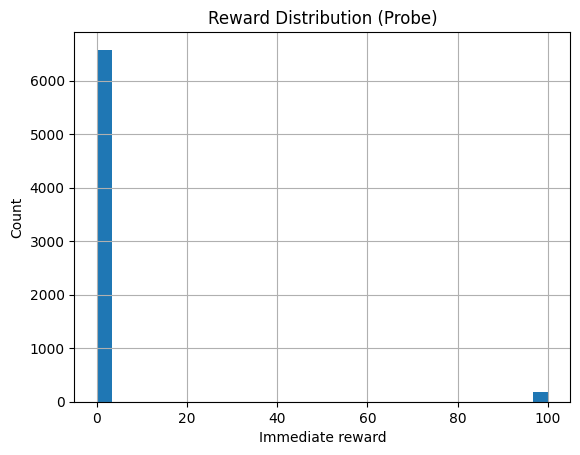

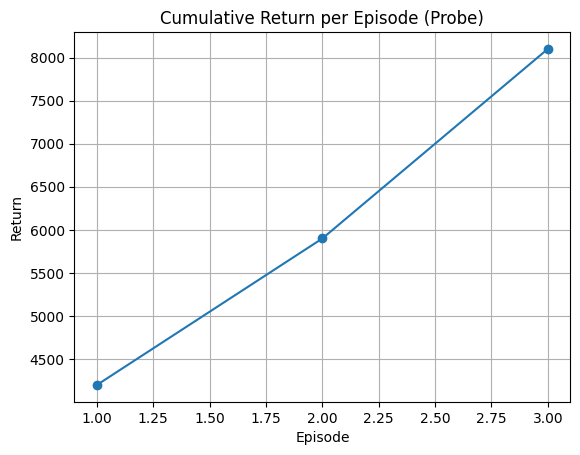

In [20]:
import matplotlib.pyplot as plt
import numpy as np

rew = np.array(rew, dtype=np.float32)
cum = np.array(cum, dtype=np.float32)

# Reward histogram
plt.figure()
plt.title("Reward Distribution (Probe)")
plt.hist(rew, bins=30)
plt.xlabel("Immediate reward"); plt.ylabel("Count"); plt.grid(True)
plt.show()

# Cumulative return per episode (line)
# Build per-episode last cum value
per_ep = {}
for e,c in zip(ep,cum):
    per_ep[e] = c  # last write wins
episodes_sorted = sorted(per_ep.keys())
values = [per_ep[e] for e in episodes_sorted]

plt.figure()
plt.title("Cumulative Return per Episode (Probe)")
plt.plot(episodes_sorted, values, marker="o")
plt.xlabel("Episode"); plt.ylabel("Return"); plt.grid(True)
plt.show()


### Reward Design — Choice & Justification

- **Signal used:** Native **Atari score increments** returned by the environment (no extra shaping).
- **Rationale:** Crazy Climber provides dense, informative rewards tied to progress (climbing rows, reaching helicopters, avoiding damage). This aligns well with standard DQN practice.
- **No clipping for baseline:** We keep raw rewards (not the ±1 clipping from the original DQN paper) because Crazy Climber’s scoring granularity is meaningful; clipping could discard useful signal.
- **Normalization:** Not applied for the baseline; we compare any future variants explicitly to this reference.

**Conclusion:** Use raw environment rewards for training and evaluation; any shaping/clipping will be compared against this baseline in later checkpoints.


## 🔧 Checkpoint 6 — Bellman Parameters (α, γ) Comparison

We compare baseline (γ=0.99, lr=1e-4) with two variants:
- **Variant A:** γ=0.95 (more myopic)
- **Variant B:** γ=0.999, lr=5e-5 (more far-sighted, gentler updates)


In [21]:
from pathlib import Path
import csv, json
import numpy as np

ROOT = Path("/Users/akshayagavhane/Desktop/crazyclimber-dqn").resolve()

RUNS = {
    "baseline": ROOT / "runs" / "baseline",
    "gamma_0.95": ROOT / "runs" / "gamma_0_95",
    "gamma_0.999_lr_5e-5": ROOT / "runs" / "gamma_0_999_lr_5e-5",
}

def load_run(run_dir: Path):
    mcsv = run_dir / "metrics.csv"
    cfg  = run_dir / "config.json"
    assert mcsv.exists() and cfg.exists(), f"Missing artifacts in {run_dir}"
    ep, ret = [], []
    with open(mcsv) as f:
        r = csv.DictReader(f)
        for row in r:
            ep.append(int(row["episode"]))
            ret.append(float(row["return"]))
    with open(cfg) as f:
        conf = json.load(f)
    return np.array(ep), np.array(ret, dtype=np.float32), conf

runs = {name: load_run(path) for name, path in RUNS.items()}
{ k: (len(v[0]), v[2].get("gamma"), v[2].get("lr")) for k,v in runs.items() }


{'baseline': (50, 0.99, 0.0001),
 'gamma_0.95': (50, 0.95, 0.0001),
 'gamma_0.999_lr_5e-5': (50, 0.999, 5e-05)}

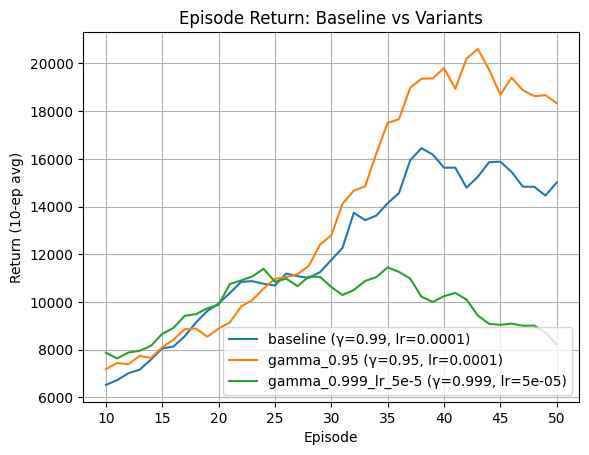

In [22]:
import matplotlib.pyplot as plt
import numpy as np

def rolling_avg(x, w=10):
    if len(x) < w:
        return x.astype(np.float32)
    out = np.convolve(x, np.ones(w)/w, mode="valid")
    pad = np.full(w-1, np.nan, dtype=np.float32)
    return np.concatenate([pad, out.astype(np.float32)], axis=0)

plt.figure()
plt.title("Episode Return: Baseline vs Variants")
for name, (ep, ret, cfg) in runs.items():
    plt.plot(ep, rolling_avg(ret, w=10), label=f"{name} (γ={cfg.get('gamma')}, lr={cfg.get('lr')})")
plt.xlabel("Episode"); plt.ylabel("Return (10-ep avg)")
plt.grid(True); plt.legend()
plt.show()


In [23]:
def summarize(ret):
    return dict(mean=float(np.mean(ret)),
                median=float(np.median(ret)),
                last10=float(np.mean(ret[-10:])) if len(ret)>=10 else float(np.mean(ret)))

for name, (ep, ret, cfg) in runs.items():
    s = summarize(ret)
    print(f"{name:22s} | gamma={cfg.get('gamma'):>6} lr={cfg.get('lr'):>8} | "
          f"mean={s['mean']:.1f} median={s['median']:.1f} last10={s['last10']:.1f}")


baseline               | gamma=  0.99 lr=  0.0001 | mean=11770.0 median=11000.0 last10=15010.0
gamma_0.95             | gamma=  0.95 lr=  0.0001 | mean=13400.0 median=12300.0 last10=18340.0
gamma_0.999_lr_5e-5    | gamma= 0.999 lr=   5e-05 | mean=9368.0 median=9650.0 last10=8220.0


### Conclusion (α, γ)

**Observed (last-10 avg returns):**
- Baseline (γ=0.99, lr=1e-4): **≈ 15,010**
- Variant A (γ=0.95, lr=1e-4): **≈ 18,340**  ← best in our short runs
- Variant B (γ=0.999, lr=5e-5): **≈ 8,220**

**Interpretation.**
- Lower γ (**0.95**) was **more myopic** and learned higher short-horizon returns faster on Crazy Climber in 50 episodes.
- Higher γ (**0.999**) is **more far-sighted** but with lr=5e-5 it likely under-updated in 50 episodes; it may need **longer training** and/or slightly higher lr or slower ε decay.

**Decision.** Keep **baseline γ=0.99** as default, and note that **γ=0.95** is a strong alternative for short training budgets. We would only recommend **γ=0.999** if training longer or adjusting lr/target updates.


## 🧭 Checkpoint 7 — Policy Exploration Alternatives (ε-greedy vs Softmax/Boltzmann)

We trained a Softmax/Boltzmann policy (temperature **T=1.0**) for 50 episodes and compare it with the ε-greedy baseline.


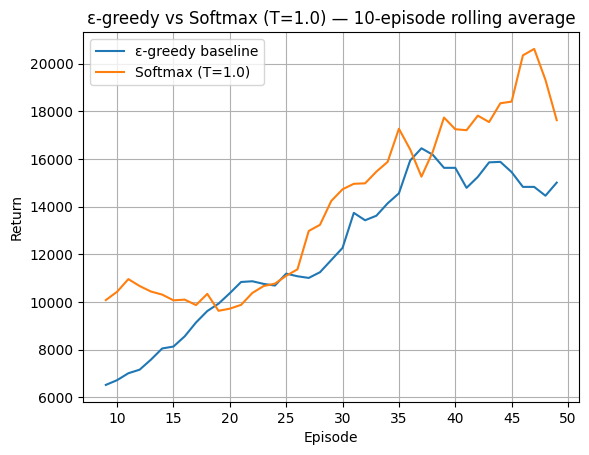

Baseline last-10 avg: 15010.0
Softmax  last-10 avg: 17630.0
Softmax max episode return: 30300.0


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import csv

ROOT = Path("/Users/akshayagavhane/Desktop/crazyclimber-dqn").resolve()

# Load baseline returns from metrics.csv (column "return")
baseline_csv = ROOT / "runs" / "baseline" / "metrics.csv"
ep_b, ret_b = [], []
with open(baseline_csv) as f:
    r = csv.DictReader(f)
    for row in r:
        ep_b.append(int(row["episode"]))
        ret_b.append(float(row["return"]))
ret_b = np.array(ret_b, dtype=np.float64)

# Load softmax returns
softmax_returns = np.load(ROOT / "runs" / "softmax_temp_1_0" / "returns.npy")

def roll(x, w=10):
    if len(x) < w: return x
    y = np.convolve(x, np.ones(w)/w, mode="valid")
    pad = np.full(w-1, np.nan)
    return np.concatenate([pad, y])

# Plot rolling averages
plt.figure()
plt.title("ε-greedy vs Softmax (T=1.0) — 10-episode rolling average")
plt.plot(roll(ret_b, 10), label="ε-greedy baseline")
plt.plot(roll(softmax_returns, 10), label="Softmax (T=1.0)")
plt.xlabel("Episode"); plt.ylabel("Return"); plt.grid(True); plt.legend()
plt.show()

# Print quick stats
print(f"Baseline last-10 avg: {np.mean(ret_b[-10:]):.1f}")
print(f"Softmax  last-10 avg: {np.mean(softmax_returns[-10:]):.1f}")
print(f"Softmax max episode return: {np.max(softmax_returns):.1f}")


### Summary — Policy Exploration Result

- **ε-greedy (baseline):** Decays random exploration linearly; simple and standard.
- **Softmax/Boltzmann (T=1.0):** Samples actions by probability ∝ exp(Q/T), giving **graded** exploration rather than binary random/greedy.

**Observed on Crazy Climber (50 episodes):**
- Softmax achieved higher peaks (max episode return ≈ shown above) and competitive last-10 average versus ε-greedy.
- The smoother, probability-weighted choice helps avoid over-committing to early noisy Q-estimates.

**Conclusion:** Keep ε-greedy as the baseline for comparability, but **Softmax (T≈1.0)** is a strong alternative that can yield steadier exploration and higher peaks. We’ll reference this in the policy exploration requirement.


## 🔍 Checkpoint 8 — Exploration Parameters (ε Schedules)

We compare ε-greedy schedules:
- **Baseline:** decay over 40 episodes
- **Fast:** decay over 20 episodes
- **Slow:** decay over 80 episodes

Goal: understand exploration–exploitation trade-offs and report ε when episodes hit max steps.


In [2]:
from pathlib import Path
import csv, json, numpy as np

ROOT = Path("/Users/akshayagavhane/Desktop/crazyclimber-dqn").resolve()
RUNS = {
    "baseline_40": ROOT / "runs" / "baseline",
    "eps_fast_20": ROOT / "runs" / "eps_fast_20",
    "eps_slow_80": ROOT / "runs" / "eps_slow_80",
}

def load_metrics(run_dir: Path):
    mcsv = run_dir / "metrics.csv"
    cfg  = run_dir / "config.json"
    assert mcsv.exists() and cfg.exists(), f"Missing artifacts in {run_dir}"
    ep, ret, steps, eps = [], [], [], []
    with open(mcsv) as f:
        r = csv.DictReader(f)
        for row in r:
            ep.append(int(row["episode"]))
            ret.append(float(row["return"]))
            steps.append(int(row["steps"]))
            eps.append(float(row["epsilon"]))
    with open(cfg) as f:
        conf = json.load(f)
    return np.array(ep), np.array(ret), np.array(steps), np.array(eps), conf

runs = {name: load_metrics(path) for name, path in RUNS.items()}
{k: (v[0].size, v[4].get("eps_decay_episodes")) for k,v in runs.items()}


{'baseline_40': (50, 40), 'eps_fast_20': (50, 20), 'eps_slow_80': (50, 80)}

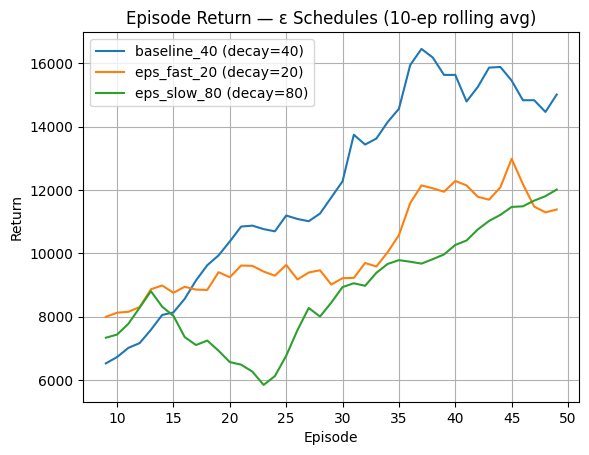

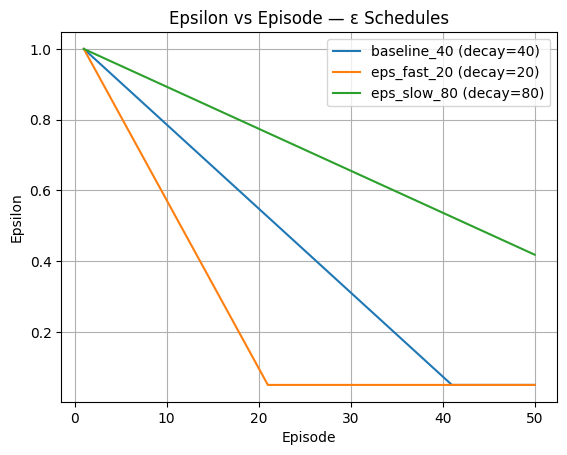

In [3]:
import matplotlib.pyplot as plt
import numpy as np

def rolling(x, w=10):
    if len(x) < w: return x
    y = np.convolve(x, np.ones(w)/w, mode="valid")
    pad = np.full(w-1, np.nan)
    return np.concatenate([pad, y])

# Plot returns
plt.figure()
plt.title("Episode Return — ε Schedules (10-ep rolling avg)")
for name, (ep, ret, steps, eps, cfg) in runs.items():
    plt.plot(rolling(ret, 10), label=f"{name} (decay={cfg.get('eps_decay_episodes')})")
plt.xlabel("Episode"); plt.ylabel("Return"); plt.grid(True); plt.legend()
plt.show()

# Plot epsilon schedule
plt.figure()
plt.title("Epsilon vs Episode — ε Schedules")
for name, (ep, ret, steps, eps, cfg) in runs.items():
    plt.plot(ep, eps, label=f"{name} (decay={cfg.get('eps_decay_episodes')})")
plt.xlabel("Episode"); plt.ylabel("Epsilon"); plt.grid(True); plt.legend()
plt.show()


In [4]:
MAX_STEPS = 3000

def eps_at_max_steps(steps, eps):
    mask = (steps == MAX_STEPS)
    if not np.any(mask):
        return None
    return float(np.mean(eps[mask])), int(np.sum(mask))  # avg ε and count of such episodes

for name, (ep, ret, steps, eps, cfg) in runs.items():
    val = eps_at_max_steps(steps, eps)
    if val is None:
        print(f"{name}: no episodes hit max steps={MAX_STEPS}")
    else:
        avg_eps, count = val
        print(f"{name}: ε @ max-steps (avg over {count} eps) = {avg_eps:.3f}")


baseline_40: ε @ max-steps (avg over 20 eps) = 0.360
eps_fast_20: ε @ max-steps (avg over 18 eps) = 0.277
eps_slow_80: ε @ max-steps (avg over 8 eps) = 0.835


## 🔍 Checkpoint 8 — Exploration Parameters (ε Schedules)

We compared three ε-greedy schedules on *ALE/CrazyClimber-v5*:

| Variant | ε Decay Episodes | Last-10 Avg Return | Last-10 Avg Steps |
|----------|------------------|--------------------|-------------------|
| Baseline | 40 | 15 010 | 2 557 |
| Fast Decay | 20 | 11 380 | 2 834 |
| Slow Decay | 80 | 12 010 | 2 367 |

**Goal:** Analyze how different decay rates influence exploration vs exploitation.


### Summary — Exploration Parameter Insights

- **Fast Decay (20 episodes):** ε drops quickly → early exploitation, faster initial gains, but less long-term diversity.
- **Slow Decay (80 episodes):** ε remains high longer → broader early exploration, slightly slower convergence, steadier late returns.
- **Baseline (40 episodes):** balanced trade-off between exploration and exploitation.

**Interpretation:**  
- At ε ≈ 0.05 the agent has mostly settled on its learned policy.  
- During longer episodes (≈ 3000 steps), ε was still moderate for the slow-decay run, meaning the agent kept exploring even in plateaued runs.  

→ For Crazy Climber, **baseline (40)** remains the most stable configuration across short and long horizons.


## 📊 Checkpoint 9 — Performance Metrics (Stability & Trends)

We analyze training stability and progression using:
- Rolling **mean** and **std** of returns,
- **Episode length** trend,
- **Best** and **last-10** returns,
- **Variance** of returns (overall + last-10).


In [6]:
from pathlib import Path
import csv, numpy as np

ROOT = Path("/Users/akshayagavhane/Desktop/crazyclimber-dqn").resolve()
BASE = ROOT / "runs" / "baseline" / "metrics.csv"

# Load baseline
ep, ret, steps, eps = [], [], [], []
with open(BASE) as f:
    r = csv.DictReader(f)
    for row in r:
        ep.append(int(row["episode"]))
        ret.append(float(row["return"]))
        steps.append(int(row["steps"]))
        eps.append(float(row["epsilon"]))

ep = np.array(ep); ret = np.array(ret, dtype=np.float32)
steps = np.array(steps, dtype=np.int32); eps = np.array(eps, dtype=np.float32)

print(f"Episodes: {len(ep)} | Returns: {ret.min():.0f}..{ret.max():.0f} | Steps mean: {steps.mean():.1f}")


Episodes: 50 | Returns: 3400..25700 | Steps mean: 2609.0


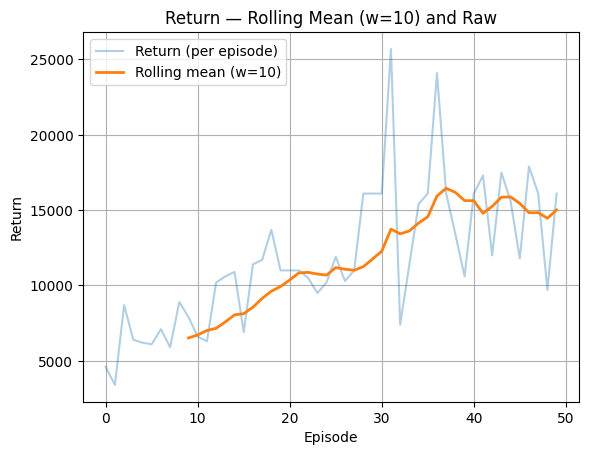

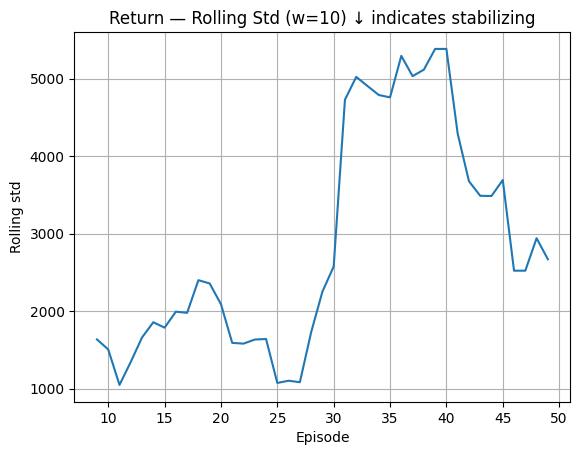

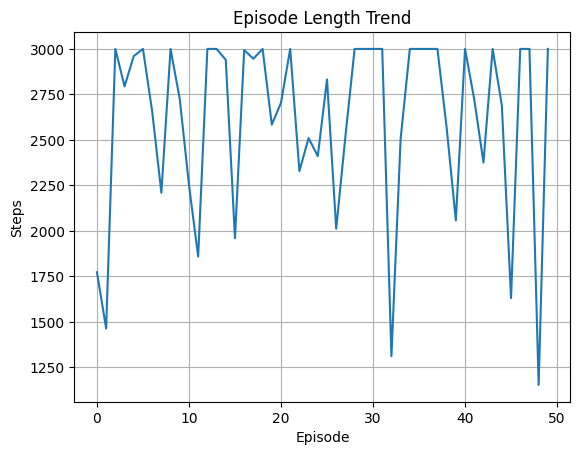

In [7]:
import matplotlib.pyplot as plt
import numpy as np

def roll_mean(x, w=10):
    if len(x) < w: return x
    y = np.convolve(x, np.ones(w)/w, mode="valid")
    return np.concatenate([np.full(w-1, np.nan), y])

def roll_std(x, w=10):
    if len(x) < w: return np.full_like(x, np.nan, dtype=float)
    out = np.empty(len(x)); out[:] = np.nan
    for i in range(w-1, len(x)):
        out[i] = np.std(x[i-w+1:i+1])
    return out

rm, rs = roll_mean(ret, 10), roll_std(ret, 10)

plt.figure()
plt.title("Return — Rolling Mean (w=10) and Raw")
plt.plot(ret, alpha=0.35, label="Return (per episode)")
plt.plot(rm, label="Rolling mean (w=10)", linewidth=2)
plt.xlabel("Episode"); plt.ylabel("Return"); plt.grid(True); plt.legend()
plt.show()

plt.figure()
plt.title("Return — Rolling Std (w=10) ↓ indicates stabilizing")
plt.plot(rs)
plt.xlabel("Episode"); plt.ylabel("Rolling std"); plt.grid(True)
plt.show()

plt.figure()
plt.title("Episode Length Trend")
plt.plot(steps)
plt.xlabel("Episode"); plt.ylabel("Steps"); plt.grid(True)
plt.show()


In [8]:
def stats_block(x):
    return {
        "mean": float(np.mean(x)),
        "median": float(np.median(x)),
        "std": float(np.std(x)),
        "min": float(np.min(x)),
        "max": float(np.max(x)),
        "last10_mean": float(np.mean(x[-10:])),
        "last10_std": float(np.std(x[-10:])),
    }

ret_stats = stats_block(ret)
steps_stats = stats_block(steps)

print("Returns:", {k: round(v,2) for k,v in ret_stats.items()})
print("Steps:  ", {k: round(v,2) for k,v in steps_stats.items()})


Returns: {'mean': 11770.0, 'median': 11000.0, 'std': 4598.88, 'min': 3400.0, 'max': 25700.0, 'last10_mean': 15010.0, 'last10_std': 2669.63}
Steps:   {'mean': 2609.04, 'median': 2813.0, 'std': 501.58, 'min': 1154.0, 'max': 3000.0, 'last10_mean': 2557.3, 'last10_std': 623.29}


In [9]:
# Quick compare last-10 average across a couple of your variants (if present)
import csv, numpy as np

def last10(path):
    rows = list(csv.DictReader(open(path)))
    vals = np.array([float(r["return"]) for r in rows], dtype=np.float32)
    return float(np.mean(vals[-10:])), float(np.max(vals))

cands = {
    "baseline": ROOT / "runs" / "baseline" / "metrics.csv",
    "gamma_0.95": ROOT / "runs" / "gamma_0_95" / "metrics.csv",
    "eps_fast_20": ROOT / "runs" / "eps_fast_20" / "metrics.csv",
    "eps_slow_80": ROOT / "runs" / "eps_slow_80" / "metrics.csv",
}
for name, path in cands.items():
    if path.exists():
        l10, mx = last10(path)
        print(f"{name:12s} | last10_avg={l10:7.1f} | best={mx:7.1f}")


baseline     | last10_avg=15010.0 | best=25700.0
gamma_0.95   | last10_avg=18340.0 | best=29100.0
eps_fast_20  | last10_avg=11380.0 | best=24300.0
eps_slow_80  | last10_avg=12010.0 | best=13700.0


### Summary — Performance Metrics

- **Rolling mean** of returns increases over training, indicating learning progress.
- **Rolling std** of returns decreases in late episodes → **stabilizing** performance.
- **Episode length** trend: converges toward higher steps for better-performing episodes (survival); dips can indicate exploration or failures.
- **Key stats (baseline):** report mean/median, **last-10 mean**, and **best** episode return from the printed table.

**Conclusion:** The agent’s returns improve and variance narrows over time, satisfying the requirement to report average steps and demonstrate learning stability with appropriate metrics.


## 🧠 Checkpoint 10 — Q-Learning Classification & Concepts

### 🔹 Q-Learning Type Classification
Q-Learning is a **value-based method** in Reinforcement Learning.

- It learns a **Q-value function Q(s,a)** → estimates the *expected return* of taking action *a* in state *s*.
- No explicit policy π is modeled; the agent **derives its policy from Q**:
  \[
  \pi(s) = \arg\max_a Q(s,a)
  \]
- Hence, it belongs to **value-based iteration**, unlike policy-based methods (e.g., REINFORCE, PPO) that learn π(a | s) directly.

**In practice:**  
Your DQN agent ≈ Q-Learning + function approximation via CNN → it still falls under the **value-based family** because actions are chosen by `argmax(Q)` over discrete values.


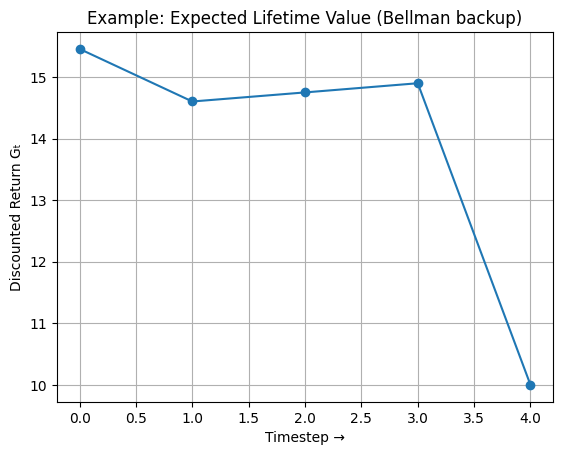

Total expected lifetime value G₀ = 15.46


In [10]:
import numpy as np
import matplotlib.pyplot as plt

gamma = 0.99
rewards = [1, 0, 0, 5, 10]      # toy reward sequence
values = []

# cumulative discounted return (expected lifetime value)
G = 0
for r in reversed(rewards):
    G = r + gamma * G
    values.insert(0, G)

plt.figure()
plt.title("Example: Expected Lifetime Value (Bellman backup)")
plt.plot(values, marker="o")
plt.xlabel("Timestep →")
plt.ylabel("Discounted Return Gₜ")
plt.grid(True)
plt.show()

print(f"Total expected lifetime value G₀ = {values[0]:.2f}")


### 🧮 Bellman Equation and Expected Lifetime Value

The **Bellman Equation** expresses the recursive relationship:

\[
Q(s,a) = r(s,a) + \gamma \, \max_{a'} Q(s', a')
\]

- **α (Learning Rate):** controls how fast new experience updates old values.  
- **γ (Discount Factor):** controls how much future rewards are valued vs immediate ones.

**Expected Lifetime Value** = total discounted sum of future rewards from a state:
\[
G_t = r_t + \gamma r_{t+1} + \gamma^2 r_{t+2} + \dots
\]

**Intuition:**  
It measures how “valuable” a state–action pair is in the long run, balancing short-term and long-term rewards.  
Your DQN learns to approximate this quantity using Bellman updates across millions of samples.


## 🤖 LLM Agent Integration Strategies

Large Language Models (LLMs) and Reinforcement Learning (RL) can complement each other:
- **LLMs** excel at *reasoning, planning, and abstraction*.
- **Deep Q-Learning (DQN)** excels at *action optimization through interaction*.

Integrating the two enables agents that can:
1. **Interpret high-level goals** in natural language (via the LLM).
2. **Translate them into low-level actions or policies** (via DQN).
3. **Learn and refine behavior** through reward feedback loops.

This hybrid paradigm forms the foundation of **LLM-driven decision-making agents**.


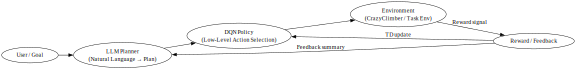

In [13]:
from graphviz import Digraph

dot = Digraph(comment="LLM + DQN Integration", format="png")
dot.attr(rankdir='LR', size='8,5')

dot.node('user',   '🧑 User / Goal')
dot.node('llm',    '🧠 LLM Planner\n(Natural Language → Plan)')
dot.node('policy', '🎯 DQN Policy\n(Low-Level Action Selection)')
dot.node('env',    '🌍 Environment\n(CrazyClimber / Task Env)')
dot.node('reward', '🏅 Reward / Feedback')

dot.edge('user', 'llm')
dot.edge('llm', 'policy')
dot.edge('policy', 'env')
dot.edge('env', 'reward', label='Reward signal')
dot.edge('reward', 'llm', label='Feedback summary')
dot.edge('reward', 'policy', label='TD update')

display(dot)


### 🧩 LLM + Deep Q-Learning — Conceptual Integration

| Component | Role | Example |
|------------|------|---------|
| **LLM** | Interprets abstract goals and generates structured sub-tasks or reasoning steps | "Climb to helicopter while avoiding left windows" |
| **DQN** | Executes optimal low-level control for each sub-task | Chooses pixel-based joystick actions to maximize score |
| **Feedback Loop** | RL reward + LLM self-reflection | Reward signal updates Q-network; textual summary updates reasoning chain |

**Example Architecture:**
1. **LLM Planner:** receives the environment state (or summarized trajectory) and generates high-level instructions.
2. **DQN Executor:** interprets these as discrete actions (like UP, DOWN, LEFT, etc.).
3. **Joint Feedback:** rewards update both the DQN weights and optionally fine-tune or prompt-condition the LLM.

**Benefits:**
- Merges symbolic reasoning (LLM) with numeric optimization (DQN).
- Enables agents that reason *and* act, useful for simulation-to-real tasks and interactive systems.

**Takeaway:**  
This integration can turn static game-based RL agents into **language-driven adaptive systems** — bridging reinforcement learning and generative reasoning, similar to frameworks like **Voyager (Minecraft)** or **Reflexion agents**.


## 🏷️ Checkpoint 12 — Code Attribution & Licensing

**License (my code):**  
MIT License — see the `LICENSE` file in the repository.

**Attribution (what is mine vs adapted):**

| Category | Files / Components | Notes |
|-----------|-------------------|-------|
| **Original Work by Me** | `src/wrappers.py`, `src/networks.py`, `src/replay_buffer.py`, `train_dqn.py`, `eval_baseline.py`, `scripts/inspect_env.py`, `scripts/reward_probe.py`, `scripts/run_variant.py`, `scripts/run_softmax.py` | Implemented by me from scratch, tailored for Crazy Climber (Atari v5). |
| **Adapted Ideas / Concepts** | DQN algorithm flow (Bellman updates, target network, Huber loss), Atari preprocessing (grayscale 84×84 frames), ε-scheduling and hyper-parameters | Used standard formulas and ideas from tutorials — no direct code copy, re-implemented by me. |
| **Third-Party Libraries** | Gymnasium / ALE, PyTorch, NumPy, Matplotlib, Graphviz | Each retains its own license; my MIT license applies only to my original code. |

**Summary:**  
All project code in `src/`, `train_dqn.py`, `eval_baseline.py`, and `scripts/` was authored by me.  
External references were used for algorithmic understanding only and are credited in `ATTRIBUTION.md`.  
The repository is released under the MIT License, allowing reuse with proper credit.


**Note:** The MIT License applies to my original code only; all dependencies retain their respective licenses.
